## Biochemical Systems Theory and S-System Models

### Introduction

Biochemical Systems Theory (BST) is a mathematical modeling framework for biochemical systems based on ordinary differential equations (ODEs), where biochemical processes are modeled using power-law expansions in the system’s variables. BST has been developed since the 1960s by [Michael Savageau](https://en.wikipedia.org/wiki/Michael_Antonio_Savageau), [Eberhard Voit](https://en.wikipedia.org/wiki/Eberhard_Voit), and others for the analysis of biochemical processes.

One of the main tools of BST is the modeling of the concentration of metabolites in a metabolic network as a dynamic S-system. For example, suppose we want to model a metabolic network that consists of a species set $\mathcal{M}$ and a reaction set $\mathcal{R}$. Then, we can write a concentation balance equation around each member of the species set $\mathcal{M}$ of the form: 

$$\frac{dX_{i}}{dt} = \sum_{r\in\mathcal{R}}\sigma_{i,r}\cdot\theta_{r}\prod_{m\in\mathcal{M}}X_{m}^{\gamma_{r,m}}-\mu{X}_{i}\qquad\forall{i}\in\mathcal{M}$$

where $\sigma_{i,r}$ denotes the stoichiometric coefficient species $i$ in reaction $r$, $X_{m}$ denotes the concentration of species $m$, and $\gamma_{r,m}$ denotes the reaction order of species $m$ in reaction $r$, and $\mu$ denotes the specific growth rate; the last term is dilution due to growth (accounts for dilution when concentrations are written in cell mass specific units). The dilution due to growth term is not present in a cell-free system (unless there is a significant volume change).

### Case study

<img src="./figs/Fig-Linear-Pathway-BST-Example.png" style="margin:auto; width:50%">

Let's build a small S-system model of a linear pathway with end-product feedback inhibition to understand better how these models work (and generally how kinetic simulations work). 

Consider the example pathway above operating in a cell-free system. A three-step pathway catalyzed by enzymes $E_{1}$, $E_{2}$ and $E_{3}$ converts metabolite $X_{1}$ to $X_{4}$. Metabolite $X_{1}$ is produced by some other process at a constant rate, and $X_{4}$ is consumed at some constant rate. Finally, metabolite $X_{4}$ inhibits the activity of enzyme $E_{1}$.

#### Setup case study environment

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/BST-Model-Case-Study`
  No Changes to `~/Desktop/julia_work/BST-Model-Case-Study/Project.toml`
  No Changes to `~/Desktop/julia_work/BST-Model-Case-Study/Manifest.toml`


In [2]:
using DifferentialEquations
using Plots

In [3]:
include("Example-Code-Library.jl");

#### a) Build the model object from the model file
The [BST model file](./models/Feedback.bst) holds information to build the model equations; however, it does not contain any information about parameter values. We build the model file using the `build` method:

* The function `build(path::String) --> Dict{String,Any}` takes a string holding the `path` to the model file and returns a model `dictionary` holding the components of the model. 

In [4]:
model_dictionary = build(joinpath(_PATH_TO_MODELS, "Feedback.bst"));

In [5]:
model_dictionary

Dict{String, Any} with 10 entries:
  "S"                        => [-1.0 0.0 … 1.0 0.0; 1.0 -1.0 … 0.0 0.0; … ; 0.…
  "list_of_static_fators"    => ["E1", "E2", "E3"]
  "list_of_dynamic_species"  => ["X1", "X2", "X3", "X4", "X5"]
  "initial_condition_array"  => [0.0, 0.0, 0.0, 0.0, 0.0]
  "number_of_dynamic_states" => 5
  "static_factors_array"     => [0.0, 0.0, 0.0]
  "number_of_static_states"  => 3
  "total_species_list"       => ["X1", "X2", "X3", "X4", "X5", "E1", "E2", "E3"]
  "G"                        => [0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 …
  "α"                        => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [6]:
model_dictionary["list_of_dynamic_species"]

5-element Vector{String}:
 "X1"
 "X2"
 "X3"
 "X4"
 "X5"

In [7]:
G = model_dictionary["G"]

8×6 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0

In [8]:
G[4,1] = 0.0;

In [9]:
icv = [10.0, 0.1, 0.1, 1.1, 0.0];
model_dictionary["initial_condition_array"] = icv;

In [10]:
model_dictionary["G"]

8×6 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0

In [11]:
model_dictionary["total_species_list"]

8-element Vector{String}:
 "X1"
 "X2"
 "X3"
 "X4"
 "X5"
 "E1"
 "E2"
 "E3"

In [12]:
model_dictionary["S"]

5×6 Matrix{Float64}:
 -1.0   0.0   0.0   0.0  1.0   0.0
  1.0  -1.0   0.0   0.0  0.0   0.0
  0.0   1.0  -1.0  -1.0  0.0   0.0
  0.0   0.0   1.0   0.0  0.0  -1.0
  0.0   0.0   0.0   1.0  0.0   0.0

In [13]:
model_dictionary["α"] = [0.0, 10.0, 10.0, 10.0, 0.1, 0.1];

In [14]:
model_dictionary["static_factors_array"] = [0.1, 0.1, 0.1];

#### b) Set test values for the model parameters in the $G$-matrix and $\alpha$-vector

In [15]:
(T, X, Z) = evaluate(model_dictionary; tspan=(0.0,100.0), Δt = 0.1);

In [16]:
X

1001×5 Matrix{Float64}:
 10.0       0.1        0.1          1.1        0.0
 10.011    -0.998753   1.13565      1.09417    0.0626674
 10.0219   -2.08743    2.06348      1.07808    0.223522
 10.0325   -3.15668    2.88445      1.05325    0.471801
 10.0429   -4.19819    3.60083      1.02074    0.796925
 10.0529   -5.20465    4.21564      0.981574   1.18858
 10.0625   -6.16978    4.73256      0.936753   1.63679
 10.0716   -7.08825    5.15584      0.887234   2.13197
 10.0802   -7.95565    5.49022      0.833932   2.665
 10.0883   -8.76847    5.74082      0.77771    3.22722
 10.0958   -9.52404    5.91306      0.719376   3.81055
 10.1027  -10.2205     6.01265      0.65969    4.40742
 10.109   -10.8567     6.04543      0.599347   5.01085
  ⋮                                           
 10.1414  -14.1371    -6.63283e-9  -0.333231  14.3366
 10.1414  -14.1371    -6.63283e-9  -0.333231  14.3366
 10.1414  -14.1371    -6.63283e-9  -0.333231  14.3366
 10.1414  -14.1371    -6.63283e-9  -0.333231  14.3366

In [17]:
1/(2.1)^2

0.22675736961451246

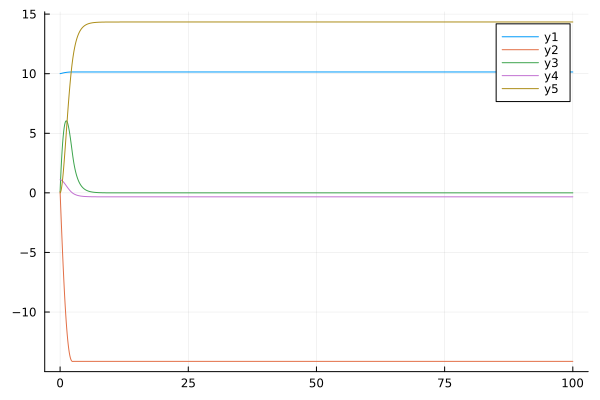

In [18]:
plot(T,X)